In [1]:
# Load Libraries
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Load project configuration
with open('config.json', 'r') as f:
    config = json.load(f)

# Extract paths
data_raw = Path(config['paths']['data_raw'])
data_processed = Path(config['paths']['data_processed'])
shapefiles = Path(config['paths']['shapefiles'])

In [4]:
## Load NYC Neighborhood Boundaries
neighborhoods = gpd.read_file(shapefiles / 'Neighborhoods' /'nynta2020.shp')
print(f"Current CRS: {neighborhoods.crs}")

Current CRS: EPSG:2263


In [6]:
# Check for invalid and null geometries
invalid_geoms = ~neighborhoods.is_valid
print(f"Invalid geometries found: {invalid_geoms.sum()}")

null_geoms = neighborhoods.geometry.isnull().sum()
print(f"Null geometries: {null_geoms}")

print(f"\nFinal count: {len(neighborhoods)} valid neighborhoods")

Invalid geometries found: 0
Null geometries: 0

Final count: 262 valid neighborhoods


In [10]:
# Calculate area in square miles
neighborhoods['area_sqmi'] = neighborhoods.geometry.area / (5280**2)

# Calculate centroid of each neighborhood
neighborhoods['centroid_x'] = neighborhoods.geometry.centroid.x
neighborhoods['centroid_y'] = neighborhoods.geometry.centroid.y

# Calculate perimeter in miles
neighborhoods['perimeter_mi'] = neighborhoods.geometry.length / 5280

print(neighborhoods['area_sqmi'].describe())

count    262.000000
mean       1.153227
std        1.043343
min        0.022803
25%        0.517219
50%        0.884682
75%        1.428300
max        7.510653
Name: area_sqmi, dtype: float64


In [13]:
# Set GEOID as index column
print(neighborhoods.head())

neighborhoods['GEOID'] = neighborhoods['NTA2020']
neighborhoods = neighborhoods.set_index('GEOID')

        BoroCode  BoroName CountyFIPS NTA2020             NTAName  NTAAbbrev  \
GEOID                                                                          
BK0101         3  Brooklyn        047  BK0101          Greenpoint      Grnpt   
BK0102         3  Brooklyn        047  BK0102        Williamsburg   Wllmsbrg   
BK0103         3  Brooklyn        047  BK0103  South Williamsburg  SWllmsbrg   
BK0104         3  Brooklyn        047  BK0104   East Williamsburg  EWllmsbrg   
BK0201         3  Brooklyn        047  BK0201    Brooklyn Heights      BkHts   

       NTAType CDTA2020                                           CDTAName  \
GEOID                                                                        
BK0101       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
BK0102       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
BK0103       0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
BK0104       0     BK01     BK01 Williamsburg-Gre

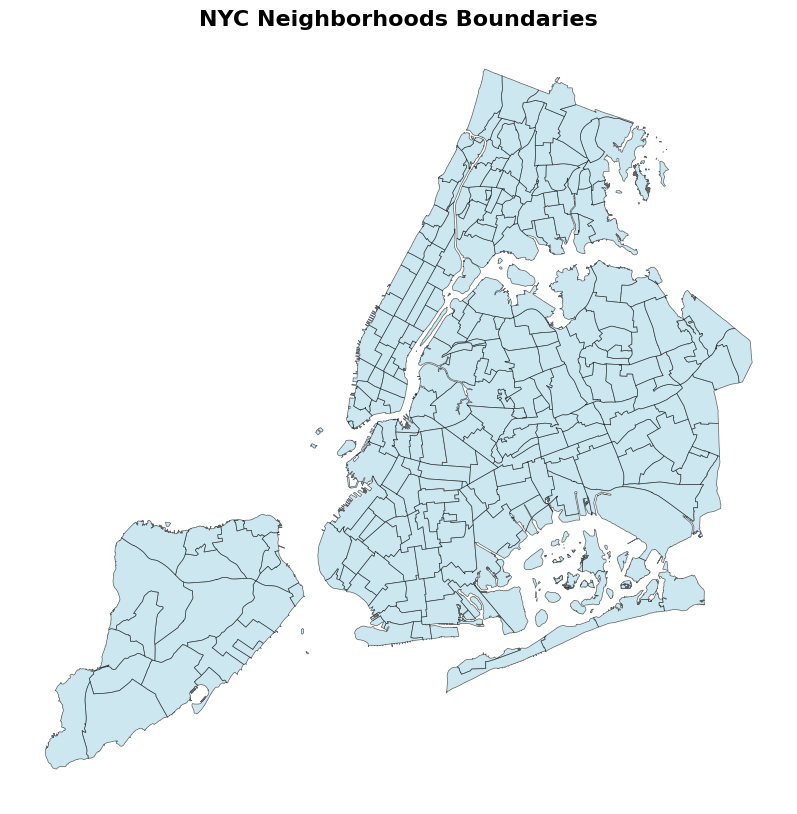

In [21]:
# Create a simple map

fig, ax = plt.subplots(figsize=(12, 10))

neighborhoods.plot(
    ax=ax,
    edgecolor='black',
    facecolor='lightblue',
    alpha=0.6,
    linewidth=0.5
)
ax.set_title('NYC Neighborhoods Boundaries', fontsize=16, fontweight='bold')
ax.set_aspect('equal')
ax.axis('off')

plt.savefig(Path(config['paths']['figures']) / '01_neighborhood_boundaries.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save Processed Data
output_file = data_processed / 'neighborhoods_clean.gpkg'
neighborhoods.to_file(output_file, driver='GPKG')

attributes_df = pd.DataFrame(neighborhoods.drop(columns='geometry'))
attributes_csv = data_processed / 'neighborhoods_attributes.csv'
attributes_df.to_csv(attributes_csv)

In [23]:
# Create a lookup table for GEOIDs
geoid_lookup = pd.DataFrame({
    'GEOID': neighborhoods.index,
    'neighborhood_name': neighborhoods.get('NTAName', neighborhoods.index),
    'borough': neighborhoods.get('BoroName', 'Unknown'),
    'area_sqmi': neighborhoods['area_sqmi']
})

# Save lookup table
lookup_path = data_processed / 'geoid_lookup.csv'
geoid_lookup.to_csv(lookup_path, index=False)